In [1]:
import numpy as np
import cv2, time, math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from skimage import color, io, exposure
from scipy.ndimage import morphology as morph
from skimage.morphology import disk
from skimage.transform import resize
from skimage import filters

In [10]:
def unite(a, linked):
    if linked[a] == a:
        return a
    else:
        linked[a] = unite(linked[a], linked)
        return linked[a]
def unionSet(a, b, linked):
    linked[unite(a, linked)] = unite(b, linked)
def connComponents(im):
    next_label = 1;
    labels = np.zeros(im.shape, dtype=int)
    linked = [0]
    h, w = im.shape
    for row in range(h):
        for column in range(w):
            if im[row, column] != 0:
                neighbors = []
                if row > 0:
                    if im[row-1][column] == im[row, column]:
                        neighbors.append((row-1, column))
                if row > 0 and column + 1 < im.shape[1]:
                    if im[row-1, column+1] == im[row, column]:
                        neighbors.append((row-1, column+1))
                if row > 0 and column > 0:
                    if im[row-1, column-1] == im[row, column]:
                        neighbors.append((row-1, column-1))
                if column > 0:
                    if (im[row, column-1] == im[row, column]):
                        neighbors.append((row, column-1))

                if len(neighbors) == 0:
                    linked.append(next_label)
                    labels[row, column] = next_label
                    next_label += 1
                
                else:
                    L = [labels[r, c] for r, c in neighbors]
                    labels[row, column] = min(L)
                    for label in L:
                        unionSet(label, labels[row, column], linked)
                        
    for row in range(im.shape[0]):
        for column in range(im.shape[1]):
            if im[row, column] != 0:
                labels[row, column] = unite(labels[row, column], linked)
    return labels    

In [5]:
def num_of_components(im):
    temp, temparr = np.unique(im.reshape(-1, im.shape[2]), axis=0, return_counts=True);
    idx = np.flipud(np.argsort(temparr))
    temp = temp[idx]
    
    fig = plt.figure(figsize=(20,500))
    # 1,6 as the first color would be for background
    
    for k in range(1, 6):
        tempim = np.zeros((im.shape[:2]));
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                if np.array_equal(temp[k].flatten(), im[i,j].flatten()):
                    tempim[i,j] = 1;
                else:
                    tempim[i,j] = 0;
        # Perform binary dilation to reduce the number of discontinuities in the image
        tempim = morph.binary_dilation(tempim, structure=np.ones((2,2))).astype(im.dtype)
        label = connComponents(tempim)
        
        plt.subplot(temp.shape[0], 3, 3*(k+1)-2)
        plt.imshow(np.tile(temp[k], (10, 10, 1)))
        plt.axis('off')
        plt.title(str(temp[k]))
        
        plt.subplot(temp.shape[0], 3, 3*(k+1)-1)
        plt.imshow(tempim, cmap='gray')
        plt.axis('off')
        plt.title('Text for given color');
        
        plt.subplot(temp.shape[0], 3, 3*(k+1))
        plt.imshow(255*np.ones((10, 10)), cmap='gray', norm=colors.Normalize(vmin=0, vmax=255, clip=True));
        plt.text(0, 5, "Number of components: " + str(np.unique(label).size-1), fontsize=15)
        plt.axis('off')

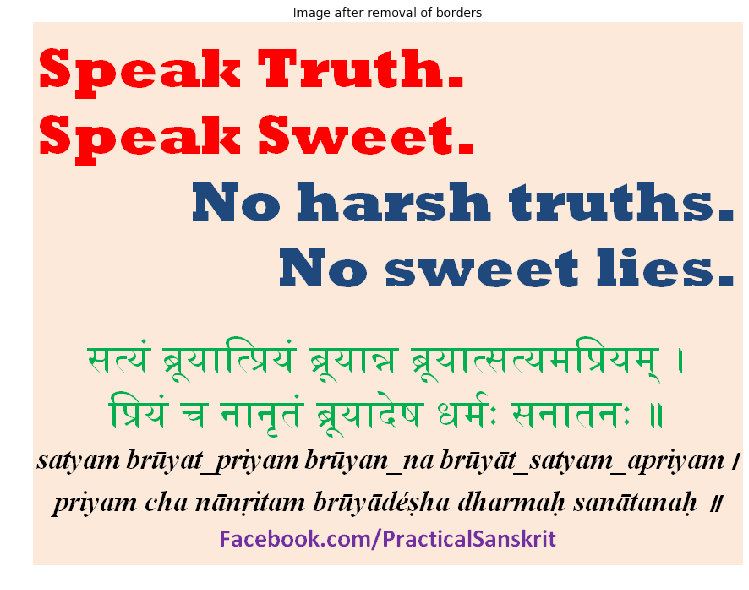

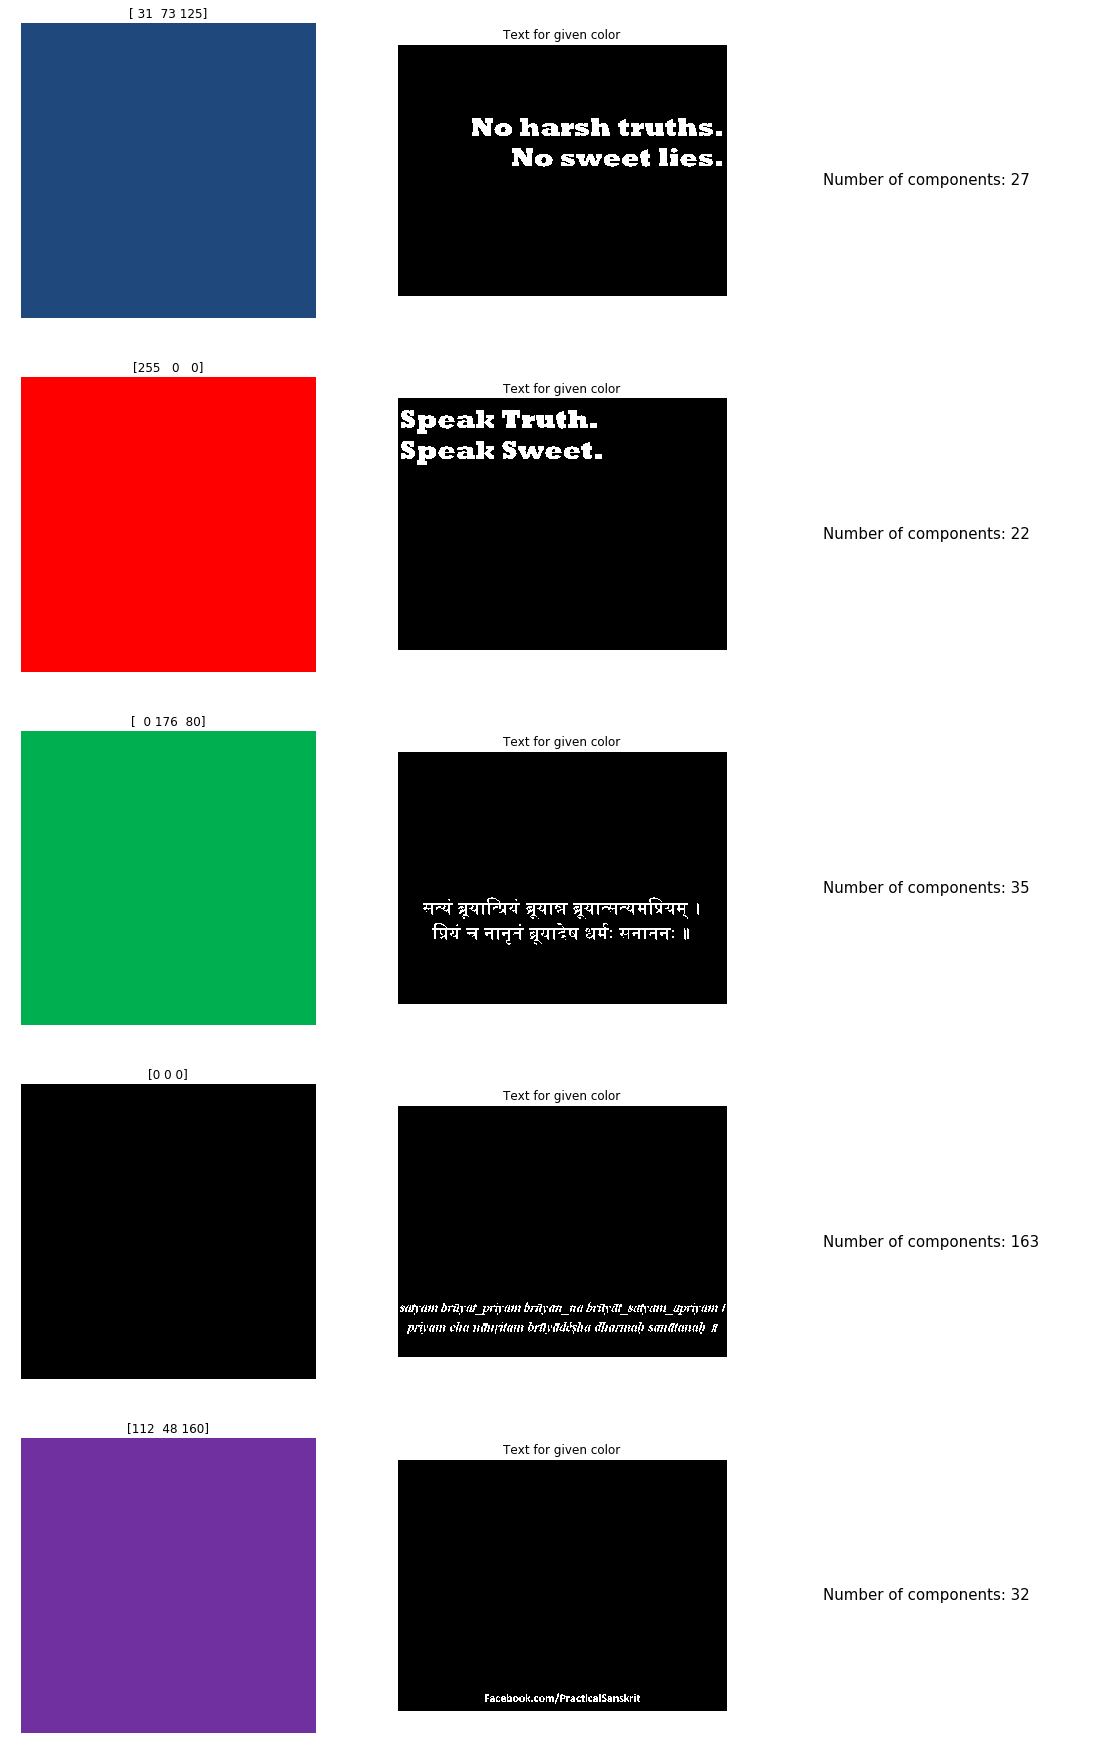

In [6]:
im = Image.open('./images/5_colors.png')
im = np.array(im)
fig = plt.figure(figsize=(20,10))
plt.axis('off')
im = im[17:-17,16:-15]
plt.imshow(im)
plt.title('Image after removal of borders');

num_of_components(im)

In [7]:
def empty_region(im, value):
    labels = connComponents(im+1)
    maxL = np.max(labels) + 1
    neighbors = [[] for i in range(maxL)]
    
    for row in range(im.shape[0]):
        for column in range(im.shape[1]):
            if im[row][column] == 1:
                
                if (row > 0 and column > 0 and im[row-1][column-1] == 0):
                    neighbors[labels[row][column]].append(labels[row-1][column-1])
                if (row + 1 < im.shape[0] and column + 1 < im.shape[1] and im[row+1][column+1] == 0):
                    neighbors[labels[row][column]].append(labels[row+1][column+1])
                
                
                if (row > 0 and im[row-1][column] == 0):
                    neighbors[labels[row][column]].append(labels[row-1][column])
                if (column > 0 and im[row][column-1] == 0):
                    neighbors[labels[row][column]].append(labels[row][column-1])
                
                
                if (row > 0 and column + 1 < im.shape[1] and im[row-1][column+1] == 0):
                    neighbors[labels[row][column]].append(labels[row-1][column+1])
                if (row + 1 < im.shape[0] and column > 0 and im[row+1][column-1] == 0):
                    neighbors[labels[row][column]].append(labels[row+1][column-1])
                
                
                if (row + 1 < im.shape[0] and im[row+1][column] == 0):
                    neighbors[labels[row][column]].append(labels[row+1][column])
                if (column + 1 < im.shape[1] and im[row][column+1] == 0):
                    neighbors[labels[row][column]].append(labels[row][column+1])
        
    
    neighbors2 = [list(set(l)) for l in neighbors]
        
    valid2 = [int(len(l) == value + 1) for l in neighbors2]
    valid3 = [int(len(l) == value ) for l in neighbors2]
    
    im2 = np.zeros(im.shape)
    im3 = np.zeros(im.shape)
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            im2[i,j] = valid2[labels[i][j]]
            im3[i,j] = valid3[labels[i][j]]
    
    fig = plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(im3, cmap = 'gray')
    plt.title('Resulting Image with one empty region')
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(im2, cmap = 'gray')
    plt.title('Resulting Image with two empty region');
    

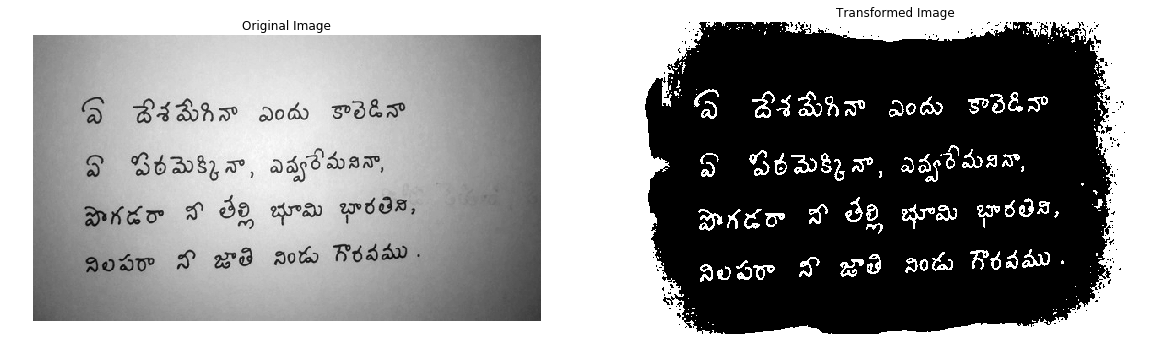

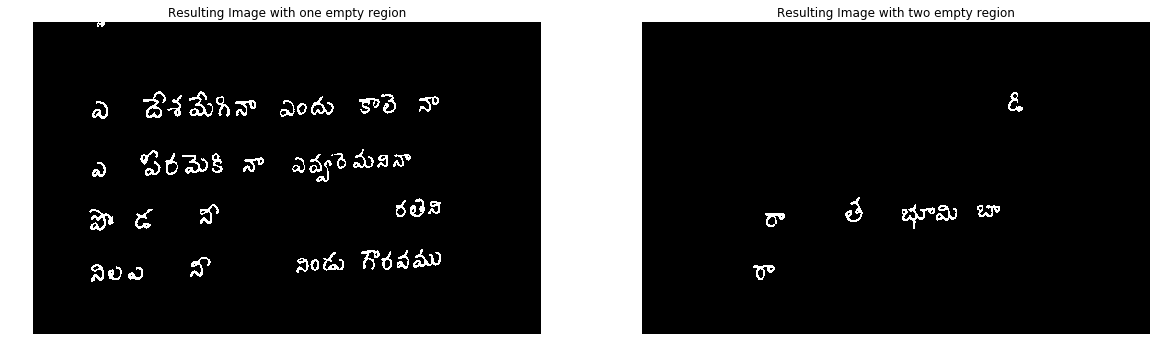

In [11]:
im = Image.open('./images/5_1.jpeg').convert('L')
im = np.array(im)
im2 = im[:,:-50]
threshold = filters.rank.otsu(im2, disk(70))
im2 = im2 < threshold;
im2 = im2.astype(int)

fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(im, cmap = 'gray')
plt.title('Original Image');

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(im2, cmap = 'gray')
plt.title('Transformed Image');

empty_region(im2, 2)

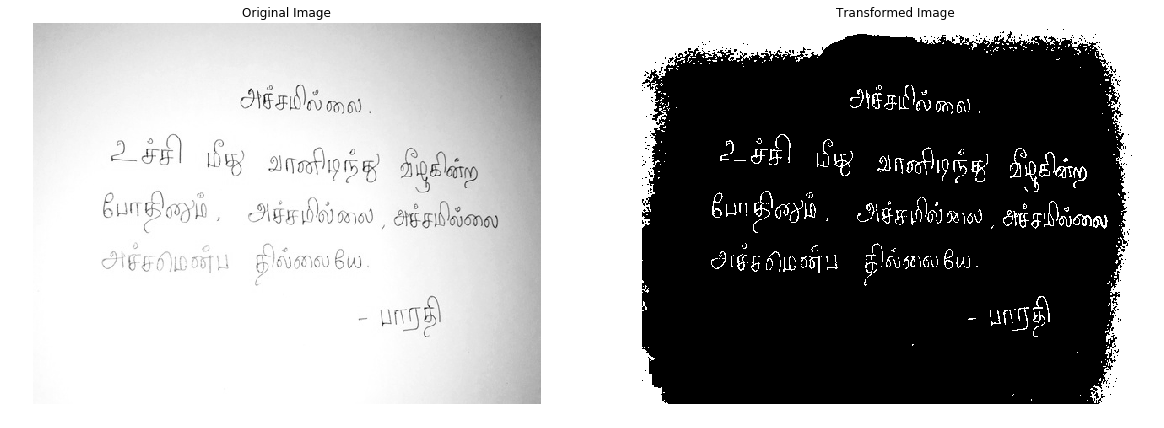

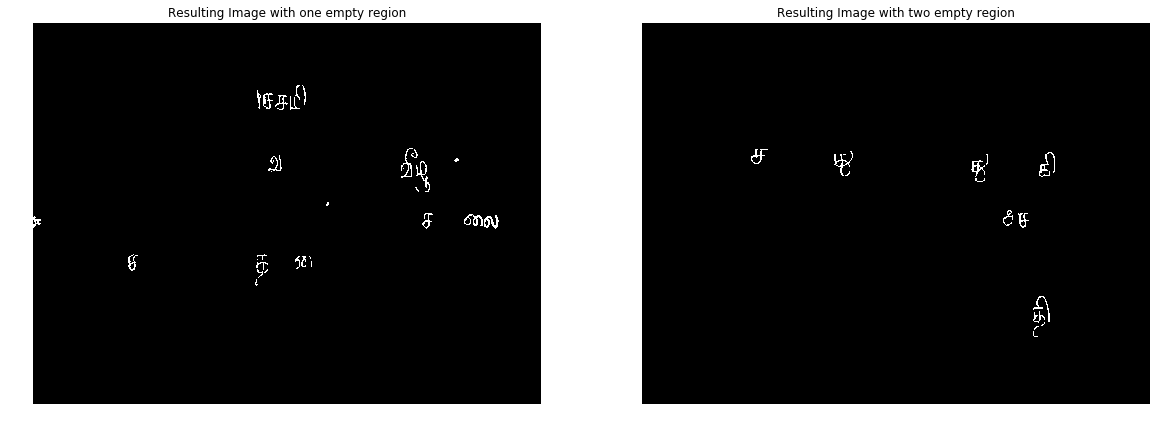

In [12]:
im = Image.open('./images/5_2.jpeg').convert('L')
im = np.array(im)
im2 = im
threshold = filters.rank.otsu(im2, disk(70))
im2 = im2 < threshold;
im2 = im2.astype(int)

fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(im, cmap = 'gray')
plt.title('Original Image');

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(im2, cmap = 'gray')
plt.title('Transformed Image');

empty_region(im2, 2)